# Реализация метода обратного распространения ошибки для двуслойной полносвязной нейронной сети

### Считывание данных:

In [13]:
import os
import functools
import operator
import gzip
import struct
import array
import numpy as np
import pandas as pd 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import os

def parse_idx(fd):
    DATA_TYPES = {0x08: 'B',  # unsigned byte
                  0x09: 'b',  # signed byte
                  0x0b: 'h',  # short (2 bytes)
                  0x0c: 'i',  # int (4 bytes)
                  0x0d: 'f',  # float (4 bytes)
                  0x0e: 'd'}  # double (8 bytes)

    header = fd.read(4)
    zeros, data_type, num_dimensions = struct.unpack('>HBB', header)

    data_type = DATA_TYPES[data_type]

    dimension_sizes = struct.unpack('>' + 'I' * num_dimensions,
                                    fd.read(4 * num_dimensions))
    data = array.array(data_type, fd.read())
    data.byteswap()  # looks like array.array reads data as little endian
    expected_items = functools.reduce(operator.mul, dimension_sizes)
    return np.array(data).reshape(dimension_sizes)

def parceFile(name):
    name = './data/' + name
    fopen = gzip.open if os.path.splitext(name)[1] == '.gz' else open
    with fopen(name, 'rb') as fd:
        return parse_idx(fd)

def loadData(type):
    if type == 'trainX':
        return parceFile('train-images-idx3-ubyte.gz')
    if type == 'trainY':
        return parceFile('train-labels-idx1-ubyte.gz')
    if type == 'testX':
        return parceFile('t10k-images-idx3-ubyte.gz')
    if type == 'testY':
        return parceFile('t10k-labels-idx1-ubyte.gz')

In [14]:
train_x = loadData('trainX')
train_y= loadData('trainY')

test_x = loadData('testX')
test_y = loadData('testY')

### Представление цифр в датасете

Каждая строка таблицы показывает одну из цифр, первый столбец `label` указывает на цифру в данной строке. Каждый элемент строки это количество серого цвета в пикселе, где 0 - его отсутствие а 255 - полностью черный.

In [15]:
print('Обучающая выборка имеет ', train_x.shape[0], 'элементов')

Обучающая выборка имеет  60000 элементов


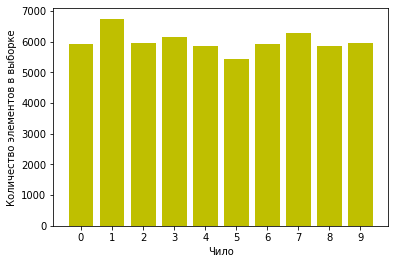

In [16]:
plt.xlabel('Чило')
plt.ylabel('Количество элементов в выборке')
plt.bar([f'{i}' for i in range(0,10)], [np.count_nonzero(train_y == i) for i in range(0,10)], color='y')
pass

Тренировочные данные довольно сбалансированные, разброс по количеству элементов для разных классов небольшой.

На вход сети должны подаваться изображения размером `w x h` нейронов, что соответствует разрешению одноканального изображения.
Рассмотрим один элемент из предоставленных данных:

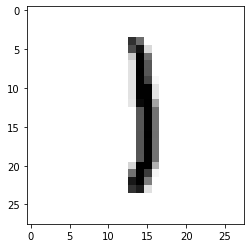

In [69]:
plt.imshow(train_x[10020].reshape(28,28), cmap='gray_r')
plt.show()
pass

Каждая строка таблицы показывает одну из цифр, первый столбец `label` указывает на цифру в данной строке. Каждый элемент строки это количество серого цвета в пикселе, где 0 - его отсутствие а 255 - полностью черный.

### Нормировка данных



In [18]:
train_x = train_x.reshape(
    train_x.shape[0], train_x.shape[1]*train_x.shape[2]).astype('float32')
train_x = train_x / 255  # normalization
train_y = np.eye(10)[train_y]  # convert label to one-hot

# flatten 28x28 to 784x1 vectors, [60000, 784]
test_x = test_x.reshape(
    test_x.shape[0], test_x.shape[1]*test_x.shape[2]).astype('float32')
test_x = test_x / 255  # normalization
test_y = np.eye(10)[test_y]

Определим функцию активации на скрытом слое `ReLU`:

In [45]:
def relu(x):
    return np.maximum(x, 0)

def reluDerivative( x):
        x[x <= 0] = 0
        x[x > 0] = 1
        return x

Функция активации на выходном слое `softMax`:


In [46]:
def softmax(x):
    log_c = np.max(x, axis=x.ndim - 1, keepdims=True)
    y = np.sum(np.exp(x - log_c), axis=x.ndim - 1, keepdims=True)
    x = np.exp(x - log_c)/y

    return x

### Построение модели

Создадим класс `NeuralNetwork` который будет содержать имплементацию основных методов нейронной сети

* `__init__` -  конструктор класса
    * `nn_input_dim` - кол-во нейронов на входе
    * `nn_hdim` - кол-во нейронов в скрытом слое
    * `nn_output_dim` - кол-во нейронов в выходном слое 
    * `seed` - инициализация для псевдорандома
    * `learningRate` - скорость обучения
    * `regTerm` -  регуляризацонный параметр
* `train` - метод в котором реализовано обучение сети
    * `train` - Объект содержащий вектор X и Y для обучения
    * `test` -  Объект содержащий вектор X и Y для тестирования значений
    * `nbEpochs` -  количестов эпох
* `computeError` -  подсчет ошибки (кросс энтропия) на тестовой или обучающей выборке
    * `data` - Объект содержащий вектор X и Y подсчета ошибок
* `computeAcuracy` - подсчет точности на тестовой или обучающей выборке
    * `data` - Объект содержащий вектор X и Y подсчета ошибок

In [91]:
class NeuralNetwork():
    def __init__(self, nn_input_dim, nn_hdim, nn_output_dim, seed=0, learningRate=0.01, regTerm=0.01, batch_size = 8):
        np.random.seed(seed)
        W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
        b1 = np.zeros((1, nn_hdim))
        W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
        b2 = np.zeros((1, nn_output_dim))
        self.model = {'W1':W1, 'W2':W2, 'b1':b1, 'b2':b2 }
        self.sizeInput = nn_input_dim
        self.sizeHidden = nn_hdim
        self.sizeOutput = nn_output_dim
        self.learningRate = learningRate
        self.regTerm = regTerm
        self.batch_size = batch_size
    
    def train(self, train, test, nbEpochs=4, printLoss=True, everyEpoch=5):
        X, Y = train
        W1, b1, W2, b2 = self.model['W1'], self.model['b1'], self.model['W2'], self.model['b2']

        for i in range(nbEpochs):
            print(f"--> Эпоха {i}")
            iteration = 0
            while iteration < len(X):

                inputs_batch = X[iteration:iteration+self.batch_size]
                labels_batch = Y[iteration:iteration+self.batch_size]

                z1 = inputs_batch.dot(W1) + b1
                a1 = relu(z1)
                z2 = a1.dot(W2) + b2
                a2 = softmax(z2)

                delta3 = (a2 - labels_batch) / a2.shape[0]
                dW2 = (a1.T).dot(delta3)
                db2 = np.sum(delta3, axis=0, keepdims=True)
                delta2 = delta3.dot(W2.T) * reluDerivative(z1)
                # delta2 = delta3.dot(W2.T)
                # delta2[a1 <= 0] = 0
                dW1 = np.dot(inputs_batch.T, delta2)
                db1 = np.sum(delta2, axis=0, keepdims=True)

                W1 += -self.learningRate * dW1
                b1 += -self.learningRate * db1
                W2 += -self.learningRate * dW2
                b2 += -self.learningRate * db2

                self.model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
                iteration += self.batch_size

            if printLoss and i % everyEpoch == 0:
                print('/' * 10)
                error_test = self.computeError(test)
                error_train = self.computeError(train)
                
                print(f"Ошибка на тестовой выборке {error_test}")
                print(f"Ошибка на обучающей выборке {error_train}")

                acc_test = self.computeAccuracy(test)
                acс_train = self.computeAccuracy(train)

                print(f"Точность на тестовой выборке {acc_test}")
                print(f"Точность на обучающей выборке {acс_train}")
                print('/' * 10)

        error_test = self.computeError(test)
        error_train = self.computeError(train)
        print("ИТОГ:")
        print(f"Ошибка на тестовой выборке {error_test}")
        print(f"Ошибка на обучающей выборке {error_train}")
        acc_test = self.computeAccuracy(test)
        acс_train = self.computeAccuracy(train)

        print(f"Точность на тестовой выборке {acc_test}")
        print(f"Точность на обучающей выборке {acс_train}")

    def computeError(self, data):
        X, Y = data
        W1, b1, W2, b2 = self.model['W1'], self.model['b1'], self.model['W2'], self.model['b2']
        z1 = X.dot(W1) + b1
        a1 = relu(z1)
        z2 = a1.dot(W2) + b2
        a2 = softmax(z2)
        
        return np.mean(-np.sum(Y * np.log(a2), axis=1))
    
    def computeAccuracy(self, data):
        X, Y = data
        W1, b1, W2, b2 = self.model['W1'], self.model['b1'], self.model['W2'], self.model['b2']
        z1 = X.dot(W1) + b1
        a1 = relu(z1)
        z2 = a1.dot(W2) + b2
        a2 = softmax(z2)
        return np.mean(np.argmax(Y, axis=1) == np.argmax(a2, axis=1))

Создадим экземпляр нейронной сети и запустим обучение:

In [93]:
network = NeuralNetwork(784, 300, 10, seed = 1, learningRate = 0.1, batch_size = 60)

network.train((train_x, train_y), (test_x, test_y), nbEpochs=20)


--> Эпоха 0
//////////
Ошибка на тестовой выборке 0.23494209447696868
Ошибка на обучающей выборке 0.2392247937889265
Точность на тестовой выборке 0.9299
Точность на обучающей выборке 0.9293
//////////
--> Эпоха 1
--> Эпоха 2
--> Эпоха 3
--> Эпоха 4
--> Эпоха 5
//////////
Ошибка на тестовой выборке 0.09422477248576255
Ошибка на обучающей выборке 0.07653052534834769
Точность на тестовой выборке 0.9727
Точность на обучающей выборке 0.97815
//////////
--> Эпоха 6
--> Эпоха 7
--> Эпоха 8
--> Эпоха 9
--> Эпоха 10
//////////
Ошибка на тестовой выборке 0.07658762395765634
Ошибка на обучающей выборке 0.04364326996428415
Точность на тестовой выборке 0.9778
Точность на обучающей выборке 0.9877833333333333
//////////
--> Эпоха 11
--> Эпоха 12
--> Эпоха 13
--> Эпоха 14
--> Эпоха 15
//////////
Ошибка на тестовой выборке 0.07064264903358458
Ошибка на обучающей выборке 0.028109649442891887
Точность на тестовой выборке 0.9788
Точность на обучающей выборке 0.99255
//////////
--> Эпоха 16
--> Эпоха 17
--